In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#pd.set_option('display.max_rows', None)

 train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of * Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.

* PassengerId - Id for each passenger in the test set.
* Transported - The target. For each passenger, predict either True or False.

In [3]:
#test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test = pd.read_csv('test.csv')


# Separate test PassengerId 
test_pass_id = test.PassengerId.copy()

In [4]:
#train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
train = pd.read_csv('train.csv')


train_pass_id = train.PassengerId.copy()

In [5]:
X = train.drop(columns = 'Transported')
y = train[['Transported']]

In [6]:
# vamos unir o DF de test e de treino para obter melhores análises
df = pd.concat([X, test], ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.3+ MB


In [7]:
nan_inicial = df.isna().sum()
nan_inicial

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
dtype: int64

In [8]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [9]:
df[['deck', 'num', 'side']] = df['Cabin'].str.split(pat = '/', expand = True)
df[['Passenger', '_Id']] = df['PassengerId'].str.split(pat = '_', expand = True)
df[['Nome', 'Sobrenome']] = df['Name'].str.split(pat = ' ', expand = True)
df.drop(columns = ['Cabin', 'Name'], inplace = True)
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,Passenger,_Id,Nome,Sobrenome
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P,0001,01,Maham,Ofracculy
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S,0002,01,Juanna,Vines
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S,0003,01,Altark,Susent
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S,0003,02,Solam,Susent
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S,0004,01,Willy,Santantines


In [10]:
df.replace({ False : 0,
                 True: 1}, inplace = True)

### HomePlantet vs Deck

In [11]:
df.groupby(['HomePlanet']).deck.value_counts() 

HomePlanet  deck
Earth       G       3700
            F       2426
            E        583
Europa      B       1124
            C       1081
            A        346
            D        296
            E        197
            T         10
Mars        F       1713
            E        508
            D        406
Name: deck, dtype: int64

- Decks *G* só transportam pessoas da terra
- Decks *A*, *B*, *C*, *T* só saem da Europa


In [12]:
df.loc[df.deck == 'G', 'HomePlanet' ] = 'Earth'
df.loc[(df.deck == 'T') | (df.deck == 'A') | (df.deck == 'B') | (df.deck == 'C'), 'HomePlanet' ] = 'Europa'

### VIP vs Deck

In [13]:

df.groupby(['VIP',]).deck.value_counts()


VIP  deck
0.0  F       4102
     G       3693
     E       1274
     B       1058
     C       1018
     D        666
     A        299
     T         10
1.0  B         58
     C         55
     A         45
     D         41
     F         41
     E         26
Name: deck, dtype: int64

- Só temos VIPs nos terminais A, B, C, D, E e F
- Terminais G e T não possuem vips

In [14]:
df.loc[(df.deck == 'G') | (df.deck == 'T'), 'VIP' ] = 0

### CryoSleep vs Deck

In [15]:
df.groupby(['CryoSleep']).deck.value_counts()

CryoSleep  deck
0.0        F       3287
           G       1674
           E       1040
           C        611
           D        538
           B        507
           A        242
           T         10
1.0        G       2018
           F        852
           B        607
           C        462
           E        252
           D        169
           A        102
Name: deck, dtype: int64

* Deck T não viaja em CryoSleep

In [16]:
df.loc[(df.deck == 'T') , 'CryoSleep' ] = 0

### CryoSleep vs VIP

In [17]:
#Avaliar os gastos das pessoas por VIP e CyooSleep
df.groupby(['CryoSleep','VIP']).agg({'RoomService' : ['mean', 'min', 'max'],
                                    'FoodCourt' : ['mean', 'min', 'max'],
                                    'ShoppingMall' : ['mean', 'min', 'max'],
                                    'Spa' : ['mean', 'min', 'max'],
                                    'VRDeck' : ['mean', 'min', 'max']})

RoomService                  FoodCourt                \
                     mean  min      max         mean  min      max   
CryoSleep VIP                                                        
0.0       0.0  342.545455  0.0  14327.0   660.739772  0.0  27071.0   
          1.0  512.165957  0.0   8030.0  2015.370213  0.0  29813.0   
1.0       0.0    0.000000  0.0      0.0     0.000000  0.0      0.0   
          1.0    0.000000  0.0      0.0     0.000000  0.0      0.0   

              ShoppingMall                        Spa                \
                      mean  min      max         mean  min      max   
CryoSleep VIP                                                         
0.0       0.0   274.284710  0.0  23492.0   461.192246  0.0  22408.0   
          1.0   308.742489  0.0   3700.0  1040.220339  0.0  15255.0   
1.0       0.0     0.000000  0.0      0.0     0.000000  0.0      0.0   
          1.0     0.000000  0.0      0.0     0.000000  0.0      0.0   

                    VRDeck                
                      mean  min      max  
CryoSleep VIP                             
0.0       0.0   451.563769  0.0  24133.0  
          1.0  1319.000000  0.0  19086.0  
1.0       0.0     0.000000  0.0      0.0  
          1.0     0.000000  0.0      0.0

In [18]:
df.loc[(df.CryoSleep == 1) , ['RoomService', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck' ] ] = 0

### VIP vs HomePlanet

In [19]:
df.groupby(['VIP','HomePlanet']).deck.value_counts()

VIP  HomePlanet  deck
0.0  Earth       G       3781
                 F       2367
                 E        576
     Europa      B       1058
                 C       1018
                 A        299
                 D        281
                 E        191
                 T         11
     Mars        F       1640
                 E        473
                 D        369
1.0  Europa      B         58
                 C         55
                 A         45
                 D         10
                 E          3
     Mars        F         38
                 D         29
                 E         22
Name: deck, dtype: int64

- Não saem VIPs from Earth
- Não saem VIPs from Europa e Deck T

In [20]:
df.loc[(df.HomePlanet == 'Earth') , 'VIP' ] = 0
df.loc[(df.HomePlanet == 'Europa') & (df.deck == 'T'), 'VIP' ] = 0

### CryoSleep vs HomePlanet

In [21]:
df.groupby(['CryoSleep','HomePlanet']).deck.value_counts()

CryoSleep  HomePlanet  deck
0.0        Earth       F       2351
                       G       1674
                       E        554
           Europa      C        611
                       B        507
                       A        242
                       D        174
                       E        117
                       T         11
           Mars        F        860
                       D        352
                       E        344
1.0        Earth       G       2018
                       E         18
                       F         18
           Europa      B        607
                       C        462
                       D        117
                       A        102
                       E         72
           Mars        F        812
                       E        153
                       D         47
Name: deck, dtype: int64

In [22]:
df.loc[(df.CryoSleep == 1) | (df.HomePlanet == 'Earth')]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,Passenger,_Id,Nome,Sobrenome
1,0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,F,0,S,0002,01,Juanna,Vines
4,0004_01,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,F,1,S,0004,01,Willy,Santantines
5,0005_01,Earth,0.0,PSO J318.5-22,44.0,0.0,0.0,483.0,0.0,291.0,0.0,F,0,P,0005,01,Sandie,Hinetthews
6,0006_01,Earth,0.0,TRAPPIST-1e,26.0,0.0,42.0,1539.0,3.0,0.0,0.0,F,2,S,0006,01,Billex,Jacostaffey
7,0006_02,Earth,1.0,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,0.0,G,0,S,0006,02,Candra,Jacostaffey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12964,9266_01,Earth,0.0,TRAPPIST-1e,40.0,0.0,0.0,865.0,0.0,3.0,0.0,F,1796,S,9266,01,Danna,Peter
12965,9266_02,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,G,1496,S,9266,02,Jeron,Peter
12966,9269_01,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,NaN,NaN,9269,01,Matty,Scheron
12967,9271_01,Mars,1.0,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,D,296,P,9271,01,Jayrin,Pore


In [23]:
nan_df = pd.DataFrame()
nan_df['inicial'] = nan_inicial
nan_df['atual'] = df.isna().sum()
nan_df['dif'] = nan_df['inicial'] - nan_df['atual']
nan_df


,inicial,atual,dif
PassengerId,0,0.0,0.0
HomePlanet,288,160.0,128.0
CryoSleep,310,309.0,1.0
Cabin,299,NaN,NaN
Destination,274,274.0,0.0
Age,270,270.0,0.0
VIP,296,135.0,161.0
RoomService,263,170.0,93.0
FoodCourt,289,180.0,109.0
ShoppingMall,306,175.0,131.0


### Group vs HomePlanet
We know that passengers from the same group are from the same HomePlanet

In [24]:
#Passageiro do mesmo grupo são sempre do mesmo HomePlanet
lista = df.groupby(['Passenger']).count().sort_values('_Id', ascending = False)
lista.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,_Id,Nome,Sobrenome
Passenger,,,,,,,,,,,,,,,,,
4005,8,8,8,8,8,8,8,8,8,8,8,7,7,7,8,7,7
0984,8,8,8,8,7,8,8,8,8,8,8,8,8,8,8,7,7
8728,8,8,7,8,8,8,8,8,8,8,8,7,7,7,8,8,8
6332,8,8,6,8,8,8,7,8,8,8,8,8,8,8,8,8,8
5756,8,8,7,8,8,8,8,8,8,8,8,7,7,7,8,7,7


In [25]:
lista = lista.loc[lista.HomePlanet > 1].index.tolist()


for i in lista:
    df.loc[(df.Passenger == i),'HomePlanet' ] = df.loc[(df.Passenger == i),'HomePlanet'].value_counts().idxmax()

In [26]:
df.groupby(['Sobrenome', 'num']).count().sort_values('Passenger', ascending = False)

PassengerId  HomePlanet  CryoSleep  Destination  Age  VIP  \
Sobrenome  num                                                               
Gibbsonton 1368            7           7          7            7    7    7   
Bine       176             7           7          7            6    7    7   
Rilley     109             7           7          7            6    7    7   
Arneras    160             7           7          7            7    7    7   
Pirejus    11              7           7          7            7    7    7   
...                      ...         ...        ...          ...  ...  ...   
Gainney    514             1           1          1            1    1    1   
           410             1           1          0            1    1    1   
           1723            1           1          1            1    1    1   
           1348            1           1          1            1    1    1   
Youngrayes 967             1           1          1            1    1    1   

                 RoomService  FoodCourt  ShoppingMall  Spa  VRDeck  deck  \
Sobrenome  num                                                             
Gibbsonton 1368            7          7             7    7       7     7   
Bine       176             7          7             7    7       7     7   
Rilley     109             7          7             6    7       7     7   
Arneras    160             7          7             6    7       7     7   
Pirejus    11              7          7             7    7       7     7   
...                      ...        ...           ...  ...     ...   ...   
Gainney    514             1          1             1    1       1     1   
           410             1          1             1    1       1     1   
           1723            1          1             0    0       1     1   
           1348            1          1             1    1       1     1   
Youngrayes 967             1          1             1    1       1     1   

                 side  Passenger  _Id  Nome  
Sobrenome  num                               
Gibbsonton 1368     7          7    7     7  
Bine       176      7          7    7     7  
Rilley     109      7          7    7     7  
Arneras    160      7          7    7     7  
Pirejus    11       7          7    7     7  
...               ...        ...  ...   ...  
Gainney    514      1          1    1     1  
           410      1          1    1     1  
           1723     1          1    1     1  
           1348     1          1    1     1  
Youngrayes 967      1          1    1     1  

[9984 rows x 16 columns]

### Sobrenome e HomePlanet

In [27]:
parcial = df.groupby(['Sobrenome', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
parcial

HomePlanet,Earth,Europa,Mars
Sobrenome,,,
Acobson,5.0,0.0,0.0
Acobsond,8.0,0.0,0.0
Adavisons,10.0,0.0,0.0
Adkinson,4.0,0.0,0.0
Admingried,0.0,4.0,0.0
...,...,...,...
Wynneyerson,2.0,0.0,0.0
Yanton,8.0,0.0,0.0
Yatters,8.0,0.0,0.0


In [28]:
parcial.loc[parcial['Earth'] > 0, 'Earth'] = 1
parcial.loc[parcial['Europa'] > 0, 'Europa'] = 1
parcial.loc[parcial['Mars'] > 0, 'Mars'] = 1
parcial.sum(axis = 1).max()

# Descobrimos que todos com o mesmo sobrenome veem do mesmo planeta

1.0

In [29]:
#Passageiro do mesmo grupo são sempre do mesmo HomePlanet
lista = df.groupby(['Sobrenome']).count().sort_values('_Id', ascending = False)
lista.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,Passenger,_Id,Nome
Sobrenome,,,,,,,,,,,,,,,,,
Buckentry,19,19,18,19,19,19,19,17,19,19,19,18,18,18,19,19,19
Belley,19,19,19,18,19,19,19,18,19,19,18,18,18,18,19,19,19
Casonston,18,18,18,18,18,18,18,18,18,18,18,17,17,17,18,18,18
Hinglendez,18,17,17,18,18,18,18,18,18,17,18,18,18,18,18,18,18
Fowlesterez,18,18,18,18,17,18,17,17,18,18,17,18,18,18,18,18,18


In [30]:
lista = lista.loc[lista.HomePlanet > 1].index.tolist()

for i in lista:
    df.loc[(df.Sobrenome == i),'HomePlanet' ] = df.loc[(df.Sobrenome == i),'HomePlanet'].value_counts().idxmax()



In [31]:
df[df['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination', 'deck']]

,PassengerId,HomePlanet,Destination,deck
2274,2443_01,NaN,TRAPPIST-1e,D
2631,2817_01,NaN,TRAPPIST-1e,F
3091,3331_01,NaN,TRAPPIST-1e,F
4548,4840_01,NaN,TRAPPIST-1e,F
5465,5826_01,NaN,55 Cancri e,E
5762,6108_01,NaN,TRAPPIST-1e,F
8613,9194_01,NaN,55 Cancri e,E
8969,0616_01,NaN,TRAPPIST-1e,E
9033,0730_01,NaN,TRAPPIST-1e,F
10583,4052_01,NaN,TRAPPIST-1e,D


In [32]:
HP = df.groupby(['HomePlanet', 'Destination'])['HomePlanet'].size().unstack().fillna(0)
HP

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,1000,1085,4778
Europa,1339,29,1769
Mars,300,70,2313


Quem vai para TRAPPIST-1e do deck D é de Marte, E e F são da Terra.

In [33]:
df.loc[(df.HomePlanet.isna()) & ~(df.deck == 'D'), 'HomePlanet'] = 'Earth'
df.loc[(df.HomePlanet.isna()) & (df.deck == 'D'), 'HomePlanet'] = 'Mars'

### Sobrenome

In [34]:
# Vamos substituir os sobrenomes 

### TotalSpend vs Age

In [35]:
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

In [36]:
df['TotalSpend'] = df['RoomService'] + df['FoodCourt'] +  df['ShoppingMall'] + df['Spa'] + df['VRDeck' ]
df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,Passenger,_Id,Nome,Sobrenome,TotalSpend
0,0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,B,0,P,0001,01,Maham,Ofracculy,0.0
1,0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,F,0,S,0002,01,Juanna,Vines,736.0
2,0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,A,0,S,0003,01,Altark,Susent,10383.0
3,0003_02,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,A,0,S,0003,02,Solam,Susent,5176.0
4,0004_01,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,F,1,S,0004,01,Willy,Santantines,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,0.0,0.0,0.0,G,1496,S,9266,02,Jeron,Peter,0.0
12966,9269_01,Earth,0.0,TRAPPIST-1e,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,NaN,NaN,9269,01,Matty,Scheron,1018.0
12967,9271_01,Mars,1.0,55 Cancri e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,D,296,P,9271,01,Jayrin,Pore,0.0
12968,9273_01,Europa,0.0,NaN,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,D,297,P,9273,01,Kitakan,Conale,3203.0


<Axes: xlabel='Age', ylabel='TotalSpend'>

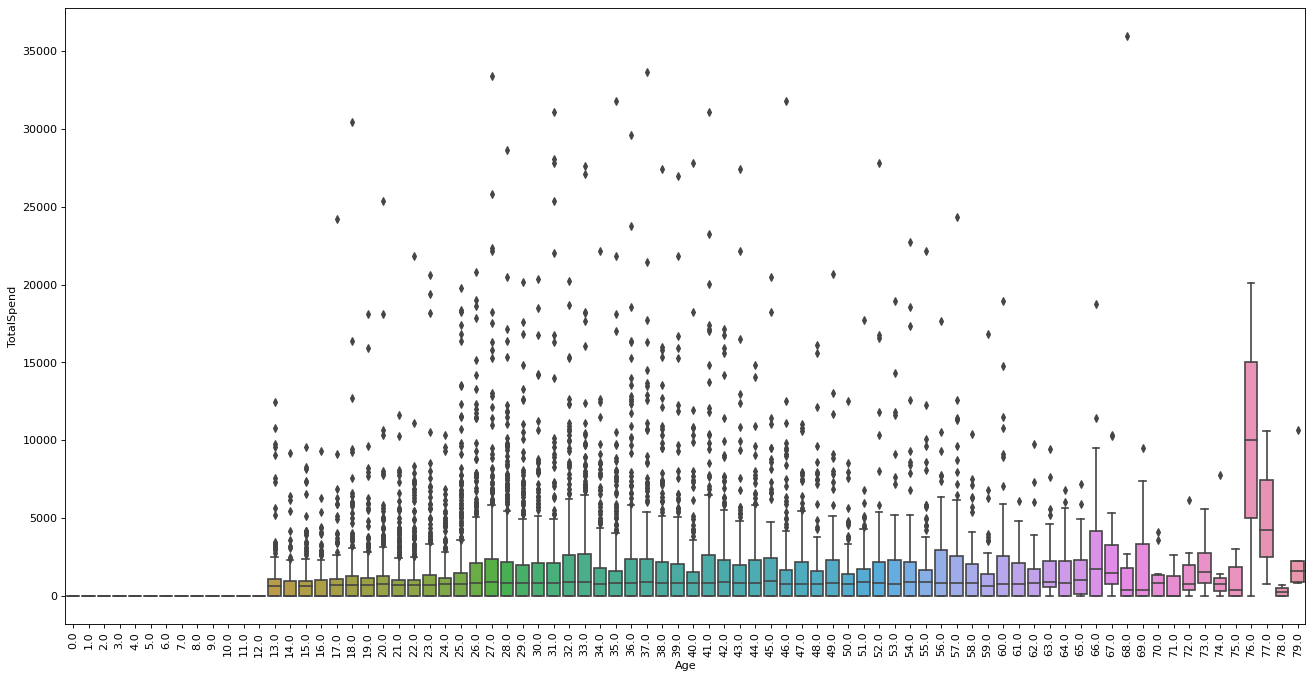

In [37]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)
plt.xticks(rotation = 90)
sns.boxplot(data = df, x = 'Age', y = 'TotalSpend')


* Age < 13 = zero gastos

In [38]:
df.loc[(df.Age < 13) , ['RoomService', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck' ] ] = 0

In [39]:
#Vamos criar um indicador para informar se gastou ou não
df['Spend'] = df['TotalSpend']
df.loc[df.Spend > 0, 'Spend'] = 1
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,Passenger,_Id,Nome,Sobrenome,TotalSpend,Spend
0,0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,B,0,P,0001,01,Maham,Ofracculy,0.0,0.0
1,0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,F,0,S,0002,01,Juanna,Vines,736.0,1.0
2,0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,A,0,S,0003,01,Altark,Susent,10383.0,1.0
3,0003_02,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,A,0,S,0003,02,Solam,Susent,5176.0,1.0
4,0004_01,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,F,1,S,0004,01,Willy,Santantines,1091.0,1.0


### VIP vs Age

In [40]:
df.loc[df.VIP == 1, "Age"].min()

18.0

In [41]:
df.loc[df.Age < 18, "VIP"] = 0

JOGANDO O NOSSO DF ATUALIZADO PARA DENTRO DO ML

In [42]:
X_novo = df.loc[df.PassengerId.isin(train_pass_id)]
X_novo.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,Passenger,_Id,Nome,Sobrenome,TotalSpend,Spend
0,0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,B,0,P,0001,01,Maham,Ofracculy,0.0,0.0
1,0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,F,0,S,0002,01,Juanna,Vines,736.0,1.0
2,0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,A,0,S,0003,01,Altark,Susent,10383.0,1.0
3,0003_02,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,A,0,S,0003,02,Solam,Susent,5176.0,1.0
4,0004_01,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,F,1,S,0004,01,Willy,Santantines,1091.0,1.0


In [43]:
X_novo.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep       216
Destination     182
Age             179
VIP              75
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
deck            199
num             199
side            199
Passenger         0
_Id               0
Nome            200
Sobrenome       200
TotalSpend        0
Spend             0
dtype: int64

In [44]:
X_novo['num'] = pd.to_numeric(X_novo['num'])
X_novo['Passenger'] = pd.to_numeric(X_novo['Passenger'])
X_novo = X_novo.drop(columns = ['PassengerId', '_Id', 'Nome', 'Sobrenome'])

C:\Users\andre\AppData\Local\Temp\ipykernel_34592\2667606820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_novo['num'] = pd.to_numeric(X_novo['num'])
C:\Users\andre\AppData\Local\Temp\ipykernel_34592\2667606820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_novo['Passenger'] = pd.to_numeric(X_novo['Passenger'])


In [45]:
colunas_numericas = X_novo.select_dtypes(include=np.number).columns
colunas_numericas

colunas_categoricas = X_novo.select_dtypes(include = 'object').columns
colunas_categoricas


Index(['HomePlanet', 'Destination', 'deck', 'side'], dtype='object')

In [46]:
X_novo.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,Passenger,TotalSpend,Spend
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,B,0.0,P,1,0.0,0.0
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,F,0.0,S,2,736.0,1.0
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,A,0.0,S,3,10383.0,1.0
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,A,0.0,S,3,5176.0,1.0
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,F,1.0,S,4,1091.0,1.0


In [47]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep       float64
Destination      object
Age             float64
VIP             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
deck             object
num              object
side             object
Passenger        object
_Id              object
Nome             object
Sobrenome        object
TotalSpend      float64
Spend           float64
dtype: object

# Estrutura do pipeline

In [48]:
# Preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm
import lightgbm as lgb



In [49]:
#Split de treino e teste
SEED = 123
X_train, X_test, y_train, y_test = train_test_split(X_novo, y, test_size=0.3, random_state=SEED)

#preprocessor
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='most_frequent'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='most_frequent'))
      ,('encoder', OneHotEncoder()) #depois testar com OrdinalEncoder
])



numeric_features = colunas_numericas 
categorical_features = colunas_categoricas

preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
]) 

In [50]:
#Estruturando os pipelines


pipe_lr = Pipeline([('preprocessor', preprocessor),
                    ('LR', LogisticRegression(random_state = SEED))])
pipe_dt = Pipeline([('preprocessor', preprocessor),
                    ('DT',DecisionTreeClassifier(random_state = SEED))])
pipe_rf = Pipeline([('preprocessor', preprocessor),
                    ('RF',RandomForestClassifier(random_state = SEED))])
pipe_knn = Pipeline([('preprocessor', preprocessor),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('preprocessor', preprocessor),
                     ('SVM', svm.SVC(random_state = SEED))])
pipe_xgb = Pipeline([('preprocessor', preprocessor),
                     ('XGB', XGBClassifier(random_state = SEED))])
pipe_lgb = Pipeline([('preprocessor', preprocessor),
                     ('LGB', lgb.LGBMClassifier(random_state = SEED))])


In [51]:
pipelines = [pipe_lr, pipe_dt, pipe_rf, pipe_knn, pipe_svm, pipe_xgb, pipe_lgb]
for pipe in pipelines:
  pipe.fit(X_train, y_train.values.ravel())

In [52]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines', 5: 'XGBoost',
             6: 'LightGBM'}
for i, model in enumerate(pipelines):
    print('{} Test Accuracy: {}'.format(grid_dict[i], model.score(X_test,y_test)))
    #print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

Logistic Regression Test Accuracy: 0.8094325153374233
Decision Trees Test Accuracy: 0.758819018404908
Random Forest Test Accuracy: 0.8194018404907976
K-Nearest Neighbors Test Accuracy: 0.7952453987730062
Support Vector Machines Test Accuracy: 0.8125
XGBoost Test Accuracy: 0.817101226993865
LightGBM Test Accuracy: 0.8209355828220859


Vamos trabalhar com o RF, SVC, XGB e LGBM

In [ ]:
#Vamos tunar os algoritimos de LR, RF, SVM e XGBOOST

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


#param_range = [1, 2, 3, 4, 5, 6]
#param_range_fl = [1.0, 0.5, 0.1]
#n_estimators = [50,100,150, 200, 250]
#learning_rates = [.1,.2,.3]

rf_param_grid = [{'RF__n_estimators': [100, 200, 500, 1000],
                    'RF__max_features': ['auto', 'sqrt', 'log2'], 
                    'RF__max_depth' : [10, 20, 30, 40, 50],
                    'RF__min_samples_split': [2, 5, 10], 
                    'RF__min_samples_leaf': [1, 2, 4], 
                    'RF__bootstrap': [True, False]}]




svm_param_grid = [{'SVM__C': uniform(0.1, 10),
              'SVM__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'SVM__gamma': ['scale', 'auto'] + list(uniform(0.01, 0.5).rvs(50)),
              'SVM__degree': randint(2, 5),
              'SVM__coef0': uniform(0, 5),
              'SVM__shrinking': [True, False],
              'SVM__tol': [1e-3, 1e-4, 1e-5],
              'SVM__max_iter': [-1, 100, 500, 1000]}]



xgb_param_grid = [{'XGB__learning_rate': uniform(0.01, 0.5),
              'XGB__max_depth': randint(3, 15),
              'XGB__n_estimators': randint(100, 1000),
              'XGB__gamma': uniform(0, 1),
              'XGB__min_child_weight': randint(1, 10),
              'XGB__subsample': uniform(0.5, 0.5),
              'XGB__colsample_bytree': uniform(0.5, 0.5),
              'XGB__reg_alpha': uniform(0, 1),
              'XGB__reg_lambda': uniform(0, 1)}]


lgb_param_grid = [{
    'LGB__boosting_type': ['gbdt', 'dart', 'goss'],
    'LGB__num_leaves': [20, 30, 40],
    'LGB__max_depth': [-1, 5, 10],
    'LGB__learning_rate': [0.01, 0.1, 1],
    'LGB__n_estimators': [50, 100, 150],
    'LGB__subsample_for_bin': [20000, 30000, 40000],
    'LGB__min_split_gain': [0.0, 0.1, 0.2],
    'LGB__min_child_weight': [0.001, 0.01, 0.1],
    'LGB__min_child_samples': [20, 30, 40],
    'LGB__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'LGB__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'LGB__reg_alpha': [0, 0.1, 0.5, 1],
    'LGB__reg_lambda': [0, 0.1, 0.5, 1],
    'LGB__importance_type': ['split', 'gain']
}]



In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rf_grid_search = RandomizedSearchCV(estimator=pipe_rf,
        param_distributions=rf_param_grid,
        scoring='accuracy',
        cv=5)

svm_grid_search = RandomizedSearchCV(estimator=pipe_svm,
        param_distributions=svm_param_grid,
        scoring='accuracy',
        cv=5)

xgb_grid_search = RandomizedSearchCV(estimator=pipe_xgb,
        param_distributions=xgb_param_grid,
        scoring='accuracy',
        cv=5)

lgb_grid_search = RandomizedSearchCV(estimator=pipe_lgb,
        param_distributions=lgb_param_grid,
        scoring='accuracy',
        cv=5)



In [ ]:

grids = [svm_grid_search, xgb_grid_search, lgb_grid_search, rf_grid_search ]
for pipe in grids:
    pipe.fit(X_train,y_train.values.ravel())
    

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

In [ ]:

grid_dict = {0: 'Support Vector Machines', 
             1: 'XGBoost', 
             2 : 'LightGBM',
             3 : 'Random Forest'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i], model.score(X_test,y_test)))
    #print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))


Support Vector Machines Test Accuracy: 0.816717791411043
XGBoost Test Accuracy: 0.821319018404908
LightGBM Test Accuracy: 0.8136503067484663
Random Forest Test Accuracy: 0.8194018404907976


In [ ]:
## Gerando o CSV de submissão:
# realizando as mudanças que fizemos no dataset original FORA do pipeline:

test = df.loc[df.PassengerId.isin(test_pass_id)]

# gerando o modelo

#modelo = pipe_lgb.fit(X_train, y_train)





# gerando y_previsto
y_previsto1 = svm_grid_search.predict(test)
y_previsto2 = xgb_grid_search.predict(test) 
y_previsto3 = lgb_grid_search.predict(test)  


# Save predictions in the format used for competition scoring
output1 = pd.DataFrame({'PassengerId': test_pass_id,
                       'Transported': y_previsto1.astype(bool)})
output2 = pd.DataFrame({'PassengerId': test_pass_id,
                       'Transported': y_previsto2.astype(bool)})
output3 = pd.DataFrame({'PassengerId': test_pass_id,
                       'Transported': y_previsto3.astype(bool)})

output1.to_csv('submission_1.csv', index=False)
output2.to_csv('submission_2.csv', index=False)
output3.to_csv('submission_3.csv', index=False)